<h1><center>Network Science for Machine Learning</center></h1>
<h1><center>Project: Comparison of Algorithms in Community Detection</center></h1>

Authors: Camille Friedrich, Jonathan Elmalem, Paul Dampierre,
Marco Farfan, Noureddine Sedki

April 2021

**Abstract.**
In this project, we will try to compare popular communities detection algorithms in term of performance, we will first investigate a family of non overlapping method and then overlapping ones, for each algorithms we will propose an implementation. In the last section, we will try to evaluate theses algorithms.

**Introduction.**
Social networks are a very popular and would be considered as part of general common knowledge to all. A social network is a social structure made up of a set of social actors (such as individuals or organizations), sets of dyadic ties, and other social interactions between actors. The social network perspective provides a set of methods for analyzing the structure of entire social entities as well as a variety of theories explaining the patterns observed in these structures. The study of these structures uses social network analysis to identify local and global patterns, locate infuential entities, and examine network dynamics.
Social networks and the analysis of them is an inherently interdisciplinary academic field which emerged from social psychology, sociology, statistics, and graph theory. Georg Simmel authored early structural theories in sociology emphasizing the dynamics of triads and a "web of group affliations". Jacob Moreno is credited with developing the first sociograms in the 1930s to study interpersonal relationships. These approaches were mathematically formalized in the 1950s and theories and methods of social networks became pervasive in the social and behavioral sciences by the 1980s. Social network analysis is now one of the major paradigms in contemporary sociology, and is also employed in a number of other social and formal sciences. Together with other complex networks, it forms part of the nascent field of network science.

**Problem Definition.**
In this project we are going to discuss the advantages and drawbacks of many algorithms. To do this
experimental evaluation of the algorithms, we will pick algorithms with different characteristics (overlapping
or non-overlapping) and a good dataset to compare the performance of the algorithms regarding some metrics.

**Methodology.**
The issue at hand is to determine which algorithm we should use if we want to detect communities in a network. Is there one "best" algorithm? Or does it depend on the network we are studying and the aim of our study? First, we have to establish the criteria we want to compare the algorithms on. We also need to choose a dataset that fits with the issue. Finally we will implement some algorithms that we will compare regarding the computational time and the metrics in order to conclude on their advantages and their drawbacks.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Imports**

In [ ]:
from helper import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import networkx as nx
import collections
import scipy.sparse as sparse
from scipy.stats.stats import pearsonr
from sklearn.cluster import KMeans
from operator import itemgetter
from scipy.cluster import hierarchy
from tqdm.notebook import tqdm
from itertools import permutations
from itertools import combinations
from collections import defaultdict

# **Network analysis**

## Graph information

In [ ]:
G = nx.karate_club_graph()
labels = {}
for i in range(G.number_of_nodes()):
    labels[i] = str(i)
G = nx.relabel_nodes(G, labels)

number of edges 78
number of nodes 34
min degree 1
max degree 17
Is connected ? True
number of connected components:  1


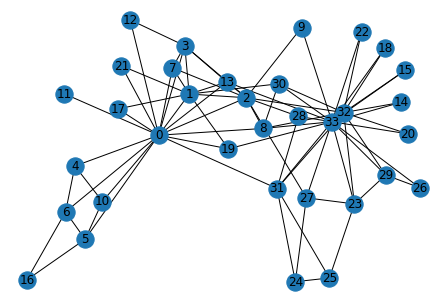

In [ ]:
def GetInfoGraph(G):
    print('number of edges', G.number_of_edges())
    print('number of nodes', G.number_of_nodes())
    print('min degree', np.min([degree[1] for degree in G.degree()])) # minimum degree
    print('max degree', np.max([degree[1] for degree in G.degree()]))# maximum degree
    print('Is connected ?', nx.is_connected(G))
    print('number of connected components: ', nx.number_connected_components(G))
    nx.draw(G, with_labels =True)

GetInfoGraph(G)

## Graph vizualization

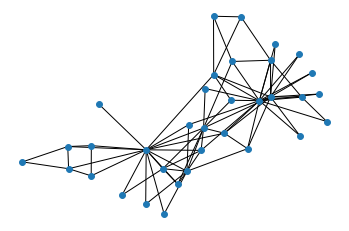

In [ ]:
sp = nx.spring_layout(G)
plt.axis('off')
options = {"node_size": 100, "node_color": "r"}
nx.draw_networkx(G, pos=sp, with_labels=False, node_size=35)
plt.show()

### Focus on the node with the largest degree

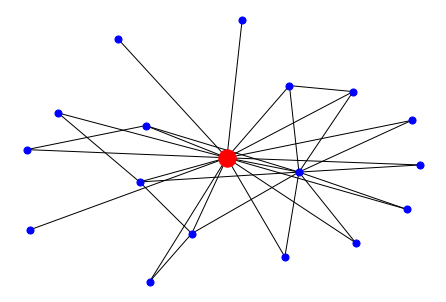

In [ ]:
# find node with largest degree
node_and_degree = G.degree()
(largest_hub, degree) = sorted(node_and_degree, key=itemgetter(1))[-1] #ego net

# Create ego graph of main hub
hub_ego = nx.ego_graph(G, largest_hub)

# Draw graph
pos = nx.spring_layout(hub_ego)
nx.draw(hub_ego, pos, node_color="b", node_size=50, with_labels=False)

# Draw ego as large and red
options = {"node_size": 300, "node_color": "r"}
nx.draw_networkx_nodes(hub_ego, pos, nodelist=[largest_hub], **options)
plt.show()

## Degree histogram

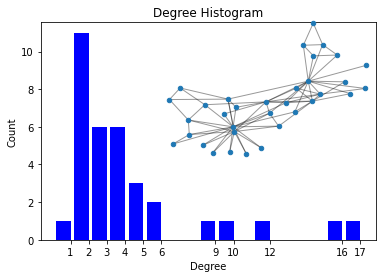

In [ ]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color="b")

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)

# draw graph in inset
plt.axes([0.4, 0.4, 0.5, 0.5])
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(G)
plt.axis("off")
nx.draw_networkx_nodes(G, pos, node_size=20)
nx.draw_networkx_edges(G, pos, alpha=0.4)
plt.show()

# **Non-Overlapping Community detection**

Community = categorization of nodes that organize knowledge.

## Girvan Newman algo

There are many ways to define "important". For example let's first take the betweenness centrality = measure of how many shortest paths pass through a particular vertex. The more shortest paths that pass through the vertex, the more central the vertex is to the network.

The Girvan–Newman algorithm detects communities by progressively removing edges from the original graph. The algorithm removes the “most valuable” edge, traditionally the edge with the highest betweenness centrality, at each step. As the graph breaks down into pieces, the tightly knit community structure is exposed and the result can be depicted as a dendrogram.

In [ ]:
def girvan_newman_algorithm(G):
    '''
    :param G: given graph
    :return partitions: a list tuples of sets of nodes in the graph. Each node set indicates a community and
    each tuple is a sequence of communities at a certain level of the algorithm.
    '''
    g = G.copy()
    partitions = []
    size=1
    
    # Repeat below process until one edge left
    while len(g.edges) > 0:
        
        # Compute betweeness centrality for every edges - use shortest path 
        ebc = nx.edge_betweenness_centrality(g)
    
        # Remove edge with highest centrality
        edge = max(ebc, key=ebc.get)
        g.remove_edge(edge[0], edge[1]) 
    
        # Retrieve communities with this edge removal
        # communities = [c for c in sorted(nx.connected_components(g), key=len, reverse=True)]
        communities = list(nx.connected_components(g))
        
        # Update partitions if communities have changed
        if len(communities) != size: 
            partitions.append(communities)
            size += 1
        
    # Use below dendograms to learn when to stop 
    return partitions

### Communities identified

In [ ]:
# Apply girvan newman algorithm and plot dendogram
%%time
girvan_newman_partition = girvan_newman_algorithm(G)

CPU times: user 118 ms, sys: 929 µs, total: 119 ms
Wall time: 119 ms


### Dendrogram of the communities

In [ ]:
def plot_dendrogram(G, partitions):

    num_of_nodes = G.number_of_nodes()
    dist = np.ones( shape=(num_of_nodes, num_of_nodes), dtype=np.float )*num_of_nodes
    d = num_of_nodes-1
    for partition in partitions:
        for subset in partition:
            for i in range(len(subset)):
                for j in range(i+1, len(subset)):
                    subsetl = list(subset)

                    dist[int(subsetl[i]), int(subsetl[j])] = d
                    dist[int(subsetl[j]), int(subsetl[i])] = d
        d -= 1



    dist_list = [dist[i,j] for i in range(num_of_nodes) for j in range(i+1, num_of_nodes)]


    Z = hierarchy.linkage(dist_list, 'complete')
    plt.figure()
    dn = hierarchy.dendrogram(Z)

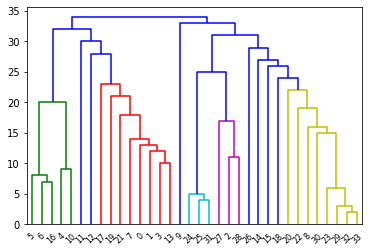

In [ ]:
plot_dendrogram(G, girvan_newman_partition)

### Let's take the first partition with 2 communities

Let's visualize this partition and evaluate it.

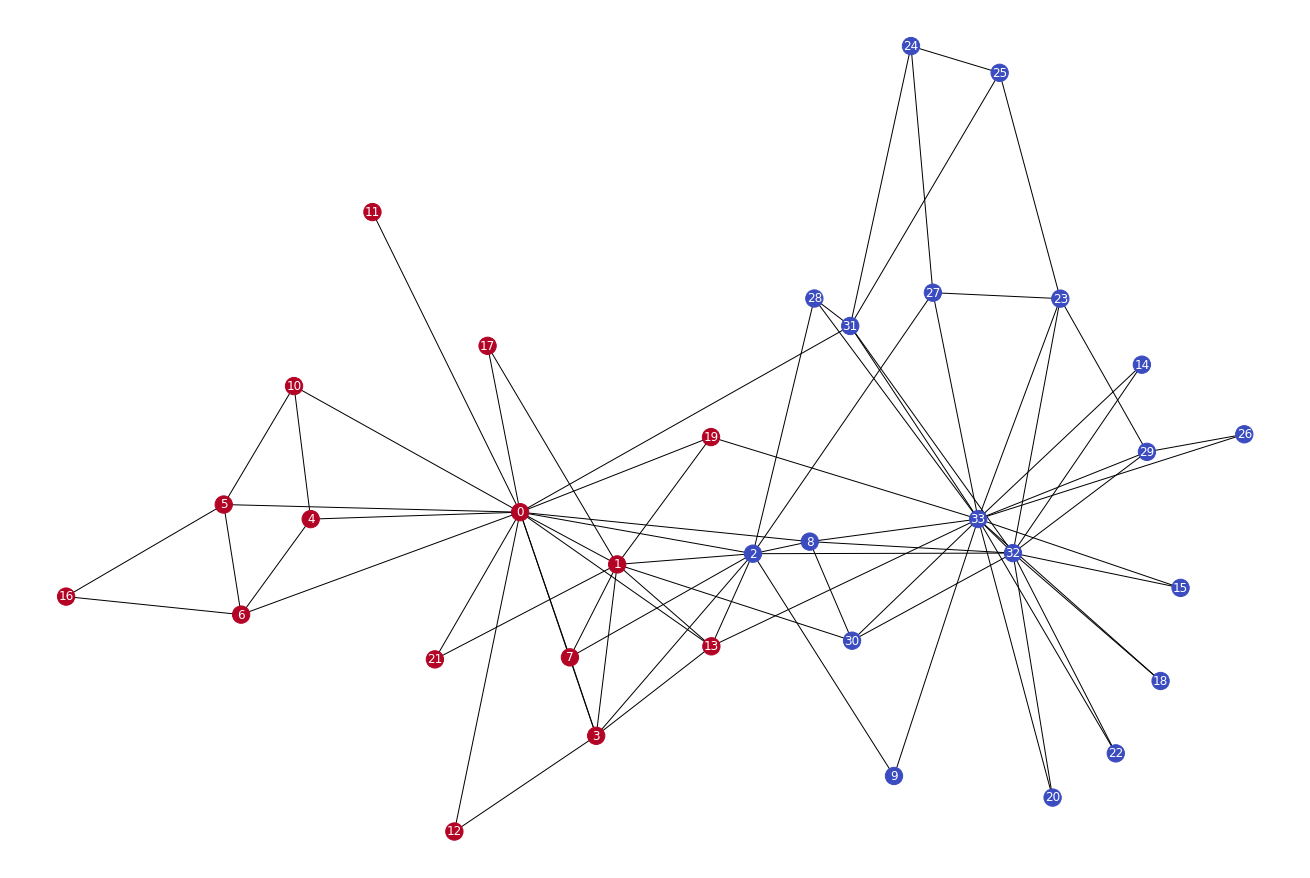

In [ ]:
# Define set of vertices 
A = list(girvan_newman_partition[0][0])
B = list(girvan_newman_partition[0][1])
val_map=[]

# Attribute a value to each cluster
for node in G.nodes():
    if node in A: val_map.append(1)   
    else: val_map.append(0) 

# Plot params
plt.figure(figsize=(18, 12))
layout = nx.fruchterman_reingold_layout(G)
nx.draw(G, node_color= val_map, pos =layout, with_labels=True, font_color='white', cmap=plt.cm.coolwarm)
plt.savefig('karate_cluster.png')

## Spectral Clustering

High values of modularity indicate good quality of partitions
Goal: find the partition that corresponds to the maximum value of
modularity.
The spectral modularity optimization method is slow and does not
scale to large networks

In [ ]:
def spectral_clustering(G, k):
    '''
    :param G: given graph
    :param k: the number of clusters
    :return partition: a list of node sets where each node set indicates a cluster
    '''
    
    # For a given undirected connected graph
    
    nodelist = list(G)  # keep the node orders
    A = np.array(nx.adjacency_matrix(G, nodelist).todense())
    D = np.diag(np.sum(A, axis=1))
    L = D - A # Laplacian matrix
    
    eigvals, eigvects = np.linalg.eig(L)
    # Sort the eigenvectors corresponding to their eigenvalues
    idx = np.argsort(eigvals)
    # eigvals = eigvals[idx]
    eigvects = eigvects[:,idx]
    
    # Retrieve top k eigenvectors wrt eigenvalue
    X = eigvects[:, 0:k]
    
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    
    partition = [set() for _ in range(k)]
    for i in range(len(nodelist)):
        partition[kmeans.labels_[i]].add(nodelist[i])
            
    return partition

### Communities identified

In [ ]:
%%time
spectral_partition = []

for k in range(2,G.number_of_nodes()+1):
    partition = spectral_clustering(G, k=k)
    spectral_partition.append(partition)

CPU times: user 2.82 s, sys: 2.05 s, total: 4.87 s
Wall time: 2.68 s


In [ ]:
spectral_partition

[[{'1',
   '13',
   '14',
   '15',
   '18',
   '19',
   '2',
   '20',
   '22',
   '23',
   '24',
   '25',
   '26',
   '27',
   '28',
   '29',
   '3',
   '30',
   '31',
   '32',
   '33',
   '7',
   '8',
   '9'},
  {'0', '10', '11', '12', '16', '17', '21', '4', '5', '6'}],
 [{'10', '16', '4', '5', '6'},
  {'0',
   '1',
   '12',
   '13',
   '14',
   '15',
   '17',
   '18',
   '19',
   '2',
   '20',
   '21',
   '22',
   '23',
   '24',
   '25',
   '26',
   '27',
   '28',
   '29',
   '3',
   '30',
   '31',
   '32',
   '33',
   '7',
   '8',
   '9'},
  {'11'}],
 [{'14',
   '15',
   '18',
   '20',
   '22',
   '23',
   '24',
   '25',
   '26',
   '27',
   '28',
   '29',
   '30',
   '31',
   '32',
   '33',
   '8',
   '9'},
  {'10', '16', '4', '5', '6'},
  {'0', '1', '12', '13', '17', '19', '2', '21', '3', '7'},
  {'11'}],
 [{'14', '15', '18', '20', '22', '26', '28', '29', '30', '32', '33', '8', '9'},
  {'10', '16', '4', '5', '6'},
  {'11'},
  {'23', '24', '25', '27', '31'},
  {'0', '1', '12', '13'

### Dendrogram of the communities

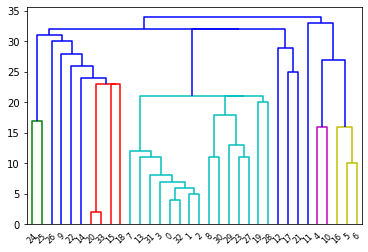

In [ ]:
plot_dendrogram(G, spectral_partition)

## Louvain Algorithm

Faster modularity optimization

A greedy modularity optimization method for community detection. The algorithm performs multiple passes :
each pass has two phases
1. Modularity Optimization
2. Community Aggregation

The Louvain method for community detection is a method to extract communities from large networks created by Blondel et al. from the University of Louvain (the source of this method’s name). The method is a greedy optimization method that appears to run in time O(n log2n) in the number of nodes in the network.

In [ ]:
'** Code from https://github.com/shogo-ma/louvain-python ** with some adjustment and refactoring'
class Louvain(object):
    def __init__(self):
        self.MIN_VALUE = 0.0000001
        self.node_weights = {}
    
    def updateNodeWeights(self, edge_weights):
        node_weights = {}
        for node in edge_weights.keys():
            node_weights[node] = sum(edge_weights[node].values())
        return node_weights

    def BestPartition(self, graph):
        node2com, edge_weights = self.initialization(graph)

        node2com = self.modularity_opt(node2com, edge_weights)
        best_modularity = self.computeModularity(node2com, edge_weights)

        partition = node2com.copy()
        new_node2com, new_edge_weights = self.community_Aggregation(node2com, edge_weights)

        while True:
            #Begining of first phase Modularity Optimization
            new_node2com = self.modularity_opt(new_node2com, new_edge_weights)
            modularity = self.computeModularity(new_node2com, new_edge_weights)
            if abs(best_modularity - modularity) < self.MIN_VALUE:
                break
            best_modularity = modularity
            #Begining of seconde phase ommunity Aggregation
            partition = self.updatePartition(new_node2com, partition)
            new_node2com, new_edge_weights = self.community_Aggregation(new_node2com, new_edge_weights)
        dict = {}
        com_id = list(set(partition.values()))
        for i in range(len(list(set(partition.values())))):

            dict[com_id[i]]=i
        for key , value in partition.items():
            partition[key] = dict[value]
        return partition

    def computeModularity(self, node2com, edge_weights):
        q = 0
        all_edge_weights = sum([sum(edge_weights[start].values()) for start in edge_weights.keys()]) / 2

        com2node = defaultdict(list)
        for node, com_id in node2com.items():
            com2node[com_id].append(node)

        for com_id, nodes in com2node.items():
            node_combinations = list(combinations(nodes, 2)) + [(node, node) for node in nodes]
            cluster_weight = sum([edge_weights[node_pair[0]][node_pair[1]] for node_pair in node_combinations])
            tot = sum([sum(list(edge_weights[n].values())) for n in nodes])
            q += (cluster_weight / (2 * all_edge_weights)) -  ((tot / (2 * all_edge_weights)) ** 2)
        return q



    def updatePartition(self, new_node2com, partition):
        reverse_partition = defaultdict(list)
        for node, com_id in partition.items():
            reverse_partition[com_id].append(node)

        for old_com_id, new_com_id in new_node2com.items():
            for old_com in reverse_partition[old_com_id]:
                partition[old_com] = new_com_id
        return partition

    def modularity_opt(self, node2com, edge_weights ):
        all_edge_weights = sum([sum(edge_weights[start].values()) for start in edge_weights.keys()]) / 2
        self.node_weights = self.updateNodeWeights(edge_weights)
        status = True
        while status:
            statuses = []
            for node in node2com.keys():
                statuses = []
                com_id = node2com[node]
                max_delta = 0.
                max_com_id = com_id
                communities = {}
                for edge in edge_weights[node].items():
                    neigh_node = edge[0]
                    node2com_copy = node2com.copy()
                    if node2com_copy[neigh_node] in communities:
                        continue
                    communities[node2com_copy[neigh_node]] = 1
                    node2com_copy[node] = node2com_copy[neigh_node]
                    # while removing the node "node" from it's own partition and compute modularity gain
                    delta_q = 2 * self.getNodeWeightInCluster(node, node2com_copy, edge_weights) - (self.node_weight(node, node2com_copy, edge_weights) * self.node_weights[node] / all_edge_weights) 
                    
                    if delta_q > max_delta:
                        #Keeping only the maximal gain updated
                        max_delta = delta_q
                        
                        max_com_id = node2com_copy[neigh_node]
                #Assigning the node to the new community
                node2com[node] = max_com_id
                statuses.append(com_id != max_com_id)

            if sum(statuses) == 0:
                break

        return node2com

    def community_Aggregation(self, node2com, edge_weights):
        com2node = defaultdict(list)

        new_node2com = {}
        new_edge_weights = defaultdict(lambda : defaultdict(float))

        for node, com_id in node2com.items():
            com2node[com_id].append(node)
            if com_id not in new_node2com:
                new_node2com[com_id] = com_id

        nodes = list(node2com.keys())
        node_pairs = list(permutations(nodes, 2)) + [(node, node) for node in nodes]
        for edge in node_pairs:
            new_edge_weights[new_node2com[node2com[edge[0]]]][new_node2com[node2com[edge[1]]]] += edge_weights[edge[0]][edge[1]]
        return new_node2com, new_edge_weights

    def node_weight(self, node, node2com, edge_weights):
        nodes = [n for n, com_id in node2com.items() if com_id == node2com[node] and node != n]
        #Removing node and computing the new weight
        weight = 0.
        for n in nodes:
            weight += sum(list(edge_weights[n].values()))
        return weight
    def getNodeWeightInCluster(self , node, node2com, edge_weights):
        edges = edge_weights[node].items()
        node_com = node2com[node]
        weights = 0.
        for edge in edges:
            if node_com == node2com[edge[0]]:
                weights += edge[1]
        return weights
    
    def initialization(self, graph):
        node2com = {}
        edge_weights = defaultdict(lambda : defaultdict(float))
        for idx, node in enumerate(graph.nodes()):
            node2com[node] = idx # Each Node is assigned to a own community

            for edge in graph[node].items(): #We loop over neighbours
                edge_weights[node][edge[0]] = 1 #We Assign weight 1 per default to each neighbours edges
        return node2com, edge_weights

### Communities identified

In [ ]:
%%time
L = Louvain()
best_partition_louvain_prev = L.BestPartition(G)

CPU times: user 3.68 ms, sys: 0 ns, total: 3.68 ms
Wall time: 3.66 ms


In [ ]:
#Grouping the values and defining them as new keys
louvain_def_dict = defaultdict(list)
for key, val in sorted(best_partition_louvain_prev.items()):
    louvain_def_dict[val].append(key)

In [ ]:
#Giving the correct format to the partition
best_partition_louvain = []
for key, value in louvain_def_dict.items():
    best_partition_louvain.append(value)

In [ ]:
best_partition_louvain

[['0', '1', '11', '12', '13', '17', '19', '2', '21', '3', '7', '9'],
 ['10', '16', '4', '5', '6'],
 ['14', '15', '18', '20', '22', '26', '29', '30', '32', '33', '8'],
 ['23', '24', '25', '27', '28', '31']]

### Visualization

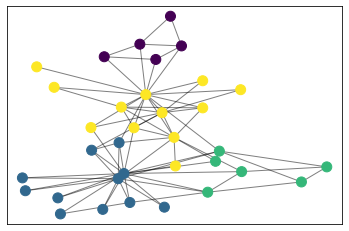

In [ ]:
# Visualization
pos = nx.spring_layout(G)
cmap = cm.get_cmap('viridis', max(best_partition_louvain_prev.values()) + 1)
nx.draw_networkx_nodes(G, pos, best_partition_louvain_prev.keys(), node_size=100,cmap=cmap, node_color=list(best_partition_louvain_prev.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

# **Overlapping community Detection**

Most of the methods presented so far perform hard clustering

## Clique Percolation Method

Two nodes belong to the same community if they can be connected
through adjacent k-cliques.

Find all cliques in G.  These are the "nodes" in G's clique graph, but to avoid confusion I'll call them cliques in what follows.
Compare every pair of cliques. If they share at least k - 1 nodes, then draw an edge between the pair of cliques in the clique graph.
Find the connected components in the clique graph--these are your percolated cliques! For each connected component return the set of nodes (from G) that are in that component.

In [ ]:
def get_percolated_cliques(G, k):
    perc_graph = nx.Graph()
    cliques = [frozenset(c) for c in nx.find_cliques(G) if len(c) >= k]
    perc_graph.add_nodes_from(cliques)

    # First index which nodes are in which cliques
    membership_dict = defaultdict(list)
    for clique in cliques:
        for node in clique:
            membership_dict[node].append(clique)

    # For each clique, see which adjacent cliques percolate
    for clique in cliques:
        for adj_clique in get_adjacent_cliques(clique, membership_dict):
            if len(clique.intersection(adj_clique)) >= (k - 1):
                perc_graph.add_edge(clique, adj_clique)

    # Connected components of clique graph with perc edges
    # are the percolated cliques
    for component in nx.connected_components(perc_graph):
        yield(frozenset.union(*component))

def get_adjacent_cliques(clique, membership_dict):
    adjacent_cliques = set()
    for n in clique:
        for adj_clique in membership_dict[n]:
            if clique != adj_clique:
                adjacent_cliques.add(adj_clique)
    return adjacent_cliques

### Communities identified

In [ ]:
mygenerator = get_percolated_cliques(G, 4) # 4 is the size of the smallest community

cpm_partitions = []

for partition in mygenerator:
    cpm_partitions.append(tuple(partition))

cpm_partitions

[('2', '13', '7', '0', '1', '3'),
 ('29', '32', '33', '23'),
 ('32', '33', '30', '8')]

## BigClam Method

In [ ]:
def gradient(F, A, row):
    """
    Compute gradient of the log of F
    F: Node community membership strength
    A: Adjacency matrix
    row: row under consideration
    """

    # find neighbour and non neighbour nodes
    neighbour = np.where(A[row, :] == 1)[1]
    n_neighbour = np.where(A[row, :] == 0)[1]

    # initialise sum
    neighbour_sum = np.zeros(F.shape[1])
    n_neighbour_sum = np.zeros(F.shape[1])

    # iterate over neighbours and apply formula *
    for n in neighbour:
        neighbour_sum += F[n,:] * np.exp(-F[row,:].dot(F[n,:])) / ( 1 - np.exp(-F[row,:].dot(F[n,:])))

    # iterate over non neighbouring nodes and apply formula
    for n in n_neighbour:
        n_neighbour_sum += F[n,:]

    grad = neighbour_sum - n_neighbour_sum
    return grad

def log_likelihood(F, A):
    """
    Compute the log of F
    F: Node community membership strength
    A: Adjacency matrix
    """
    # find the predicted value of A from F
    A_hat = F.dot(F.T)

    # compute the log likelihood of G knowing F
    edges_sum = np.sum(A*np.log(1.-np.exp(-1.*A_hat)))
    n_edges_sum = np.sum((1-A)*A_hat)

    log_l = edges_sum - n_edges_sum
    return log_l

def train(A, C, lr=0.001, iterations=1000):
    """
    Find the matrix F by gradient descent
    A: Adjacency matrix
    C: Number of communities
    lr: Learning Rate
    iterations: number of iterations in gradient descent
    """
    track = []
    # initialise F
    F = np.random.rand(A.shape[0], C)

    # loop to converge in gradient descent
    for _ in tqdm(range(iterations)):

        # loop over F to compute every row
        for i in range(A.shape[0]):

            # compute gradient of the loss of the row
            grad = gradient(F, A, i)

            # compute the new value for the row of F
            F[i, :] += lr * grad

            # ensure the row of F is non-negative
            F[i,:] = np.maximum(1e-5, F[i,:])

        # compute the log-likelihood of F and A
        log_l = log_likelihood(F, A)

        # keep track of log likelihood
        track.append(log_l)

    plt.plot(np.arange(len(track)), track)
    plt.title('log-likelihood over time')
    plt.show()

    return F


def cutoff(F, lim):
    F = F > lim
    return F

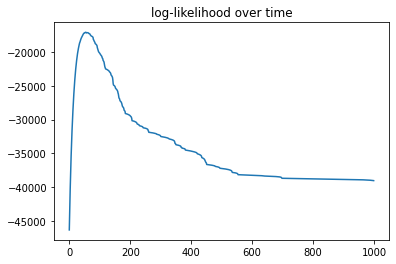

In [ ]:
# get transition matrix A
A = nx.to_numpy_matrix(G)
C = 6

F = train(A, C)

### Communities identified

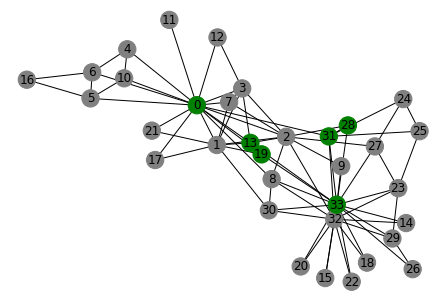

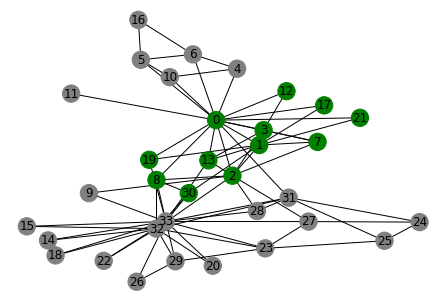

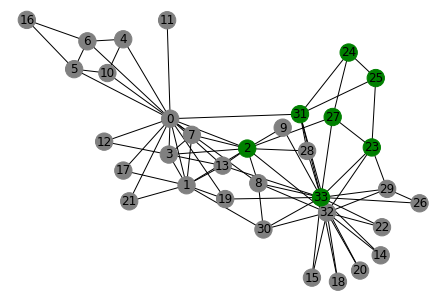

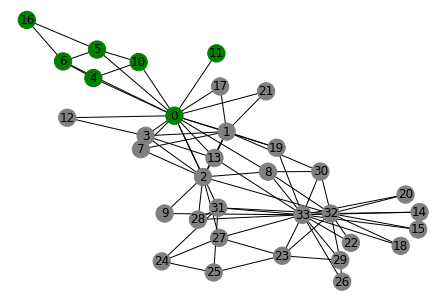

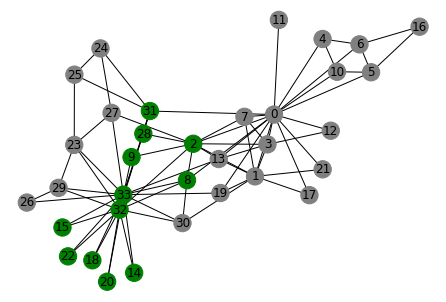

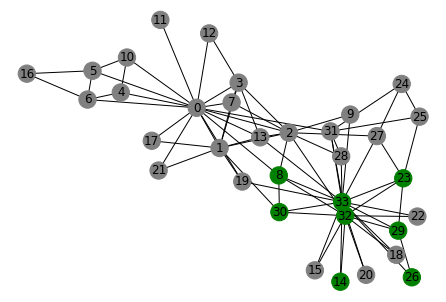

In [ ]:
community = cutoff(F, 0.1)
for j in range(C):
    colours = []
    for i in range(community.shape[0]):
        if community[i, j]:
            colours.append('green')
        else:
            colours.append('grey')

    nx.draw(G, node_color=colours, with_labels=True)
    plt.show()

bigclam_partition = [set() for i in range(C)]
for i in range(C):
    for j in np.where(community[:, i])[0]:
        bigclam_partition[i].add(str(j))

In [ ]:
print(bigclam_partition)

[{'33', '28', '13', '31', '19', '0'}, {'1', '3', '12', '30', '2', '21', '13', '17', '19', '0', '8', '7'}, {'27', '33', '23', '2', '31', '25', '24'}, {'11', '16', '6', '10', '5', '0', '4'}, {'22', '33', '28', '2', '15', '18', '14', '20', '31', '32', '9', '8'}, {'33', '23', '30', '32', '14', '26', '29', '8'}]


# **Implementing Metrics**

## Modularity

In [ ]:
def compute_modularity(G, partition):
    '''
    :param G: input graph.
    :param partition: a list of node sets where each set represents a community.
    :return: modularity value for a given partition of the network G.
    '''    
    num_of_edges = G.number_of_edges()
    modularity_list = []
    
    # Loop over communities
    for subset in partition:
        nodelist = list(subset)
        G_subset = G.subgraph(nodelist)
        A = nx.adj_matrix(G_subset)
        
        s = 0
        # For all pair of nodes inside these communities
        for i in range(G_subset.number_of_nodes()):
            for j in range(G_subset.number_of_nodes()):
                s += A[i, j] - ( ( nx.degree(G, nodelist[i])*nx.degree(G, nodelist[j]) ) / (2.0*num_of_edges) )
            
        modularity_list.append(s / (2.0*num_of_edges))
            
    return np.sum(modularity_list)

### Modularity on Girvan Newman

In [ ]:
# Print modularity scores for all partitions and saving values for later plotting
x_g_n = []
y_g_n = []

for partition in girvan_newman_partition:
    x_val = len(partition)
    y_val = compute_modularity(G, partition)
    x_g_n.append(x_val)
    y_g_n.append(y_val)
    print("Number of communities=",x_val,"Modularity=",y_val)

Number of communities= 2 Modularity= 0.35996055226824464
Number of communities= 3 Modularity= 0.34878369493754124
Number of communities= 4 Modularity= 0.36324786324786346
Number of communities= 5 Modularity= 0.40129848783694944
Number of communities= 6 Modularity= 0.3925049309664695
Number of communities= 7 Modularity= 0.3762327416173571
Number of communities= 8 Modularity= 0.3583168967784353
Number of communities= 9 Modularity= 0.341715976331361
Number of communities= 10 Modularity= 0.3247863247863249
Number of communities= 11 Modularity= 0.3159105851413545
Number of communities= 12 Modularity= 0.2986522024983565
Number of communities= 13 Modularity= 0.2804076265614728
Number of communities= 14 Modularity= 0.2628205128205129
Number of communities= 15 Modularity= 0.247534516765286
Number of communities= 16 Modularity= 0.22682445759368838
Number of communities= 17 Modularity= 0.2089086127547666
Number of communities= 18 Modularity= 0.1898422090729783
Number of communities= 19 Modularity

Text(0.5, 0.98, 'Girvan Newman')

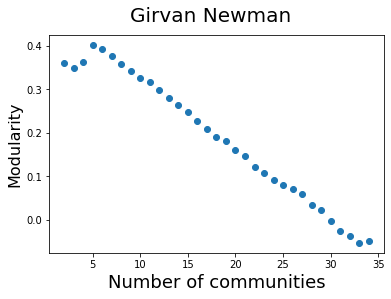

In [ ]:
fig = plt.figure()
plt.scatter(x_g_n, y_g_n)
plt.xlabel('Number of communities', fontsize=18)
plt.ylabel('Modularity', fontsize=16)
fig.suptitle('Girvan Newman', fontsize=20)

In [ ]:
# Now combine both girvan_newman_algorithm and modularity to obtain the best partition based on modularity
best_partition_eval_g_n = -100 
for partition in girvan_newman_partition:
    mod = compute_modularity(G, partition)
    if mod > best_partition_eval_g_n:
        best_partition_eval_g_n = mod
        best_partition_g_n = partition
print(best_partition_g_n)
print(best_partition_eval_g_n)

[{'13', '7', '11', '19', '12', '17', '0', '21', '1', '3'}, {'2', '25', '24', '31', '27', '28'}, {'10', '4', '16', '5', '6'}, {'15', '33', '18', '23', '14', '8', '32', '29', '26', '22', '20', '30'}, {'9'}]
0.40129848783694944


### Modularity on Spectral Clustering

In [ ]:
# Print modularity scores for all partitions and saving values for later plotting
x_spec = []
y_spec = []

for partition in spectral_partition:
    x_val = len(partition)
    y_val = compute_modularity(G, partition)
    x_spec.append(x_val)
    y_spec.append(y_val)
    print("Number of communities=",x_val,"Modularity=",y_val)

Number of communities= 2 Modularity= 0.2339743589743593
Number of communities= 3 Modularity= 0.1314102564102564
Number of communities= 4 Modularity= 0.3911078238001316
Number of communities= 5 Modularity= 0.4031886916502302
Number of communities= 6 Modularity= 0.3980111768573309
Number of communities= 7 Modularity= 0.3745890861275478
Number of communities= 8 Modularity= 0.2635601577909271
Number of communities= 9 Modularity= 0.31886916502301127
Number of communities= 10 Modularity= 0.16083168967784367
Number of communities= 11 Modularity= 0.15458579881656814
Number of communities= 12 Modularity= 0.14603879026955963
Number of communities= 13 Modularity= 0.127629848783695
Number of communities= 14 Modularity= 0.06878698224852071
Number of communities= 15 Modularity= 0.13584812623274165
Number of communities= 16 Modularity= 0.10798816568047338
Number of communities= 17 Modularity= 0.05062458908612756
Number of communities= 18 Modularity= 0.19855358316896785
Number of communities= 19 Modul

Text(0.5, 0.98, 'Spectral Clustering')

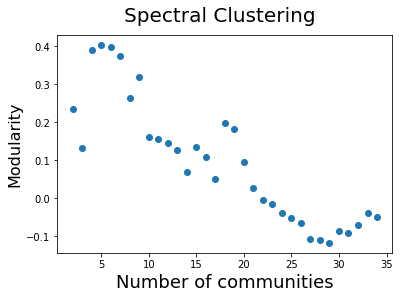

In [ ]:
fig = plt.figure()
plt.scatter(x_spec, y_spec)
plt.xlabel('Number of communities', fontsize=18)
plt.ylabel('Modularity', fontsize=16)
fig.suptitle('Spectral Clustering', fontsize=20)

In [ ]:
# Now combine both spectral clustering and modularity to obtain the best partition based on modularity
best_partition_eval_spec = -100 
for partition in spectral_partition:
    mod = compute_modularity(G, partition)
    if mod > best_partition_eval_spec:
        best_partition_eval_spec = mod
        best_partition_spec = partition
print(best_partition_spec)
print(best_partition_eval_spec)

[{'15', '22', '18', '33', '9', '8', '32', '29', '26', '14', '28', '20', '30'}, {'10', '4', '16', '5', '6'}, {'11'}, {'25', '24', '23', '31', '27'}, {'2', '13', '21', '7', '12', '17', '0', '19', '1', '3'}]
0.4031886916502302


### Modularity on Louvain

In [ ]:
best_partition_eval_louvain = compute_modularity(G, best_partition_louvain)

### Modularity Comparison

In [ ]:
df = pd.DataFrame({
    "Girvan-Newman":[best_partition_eval_g_n],
    "Spectral clustering": [best_partition_eval_spec],
    "Louvain Algo": [best_partition_eval_louvain]})

df

,Girvan-Newman,Spectral clustering,Louvain Algo
0,0.401298,0.403189,0.418803


## Conductance

In [ ]:
def compute_conductance(G, partition):
    '''
    :param G: input graph.
    :param partition: a list of node sets where each set represents a community.
    :return: - dictionary with values of min conductance per community size
             - conductance average value for a given partition of the network G.
    '''  
    nodes_list = np.array(list(G.nodes()))
    A = nx.adj_matrix(G)

    conductances = []
    conductances_dict = {}
    # Loop over communities
    for subset in partition:
        nodes_subset = list(subset)
        #Numerator of conductance
        numer = 0
        #Denominator of conductance
        denom1 = 0
        denom2 = 0
        #Iterates through all nodes
        for i in range(G.number_of_nodes()):
            for j in range(G.number_of_nodes()):
                #Numerator is defined as number of edges with one endpoint in subset and one endpoint out of subset
                if nodes_list[i] in nodes_subset and nodes_list[j] not in nodes_subset:
                    numer += A[i,j]
                #Denominator is defined as the sum of degrees of nodes in subset
                if nodes_list[i] in nodes_subset:
                    denom1 += A[i,j]
                if nodes_list[i] not in nodes_subset:
                    denom2 += A[i,j]
        
        denom = min(denom1, denom2)
        #Saving conductance value for current cut
        conductance = numer/denom
        conductances.append(conductance)

        len_subset = len(nodes_subset)
        #Stores the minimum conductance for a given community size
        if len_subset in conductances_dict:
            if conductance < conductances_dict[len_subset]:
                conductances_dict[len_subset] = conductance
        else:
            conductances_dict[len_subset] = conductance

    #Conductance of a graph as the average conductance value across all cuts
    return conductances_dict, np.amin(conductances), np.mean(conductances)

### Conductance on Girvan Newman

In [ ]:
# Print conductance scores for all partitions and saving values for later plotting
x_g_n = []
y_g_n = []
y_min = []

for partition in girvan_newman_partition:
    x_val = len(partition)
    conductances_dict, conductance_min, conductance = compute_conductance(G, partition)
    x_g_n.append(x_val)
    y_g_n.append(conductance)
    y_min.append(conductance_min)
    print("Number of communities=",x_val,", conductance=",conductance,", conductance_min=",conductance_min)

Number of communities= 2 , conductance= 0.15151515151515152 , conductance_min= 0.15151515151515152
Number of communities= 3 , conductance= 0.4426619132501486 , conductance_min= 0.15151515151515152
Number of communities= 4 , conductance= 0.42661764705882355 , conductance_min= 0.17647058823529413
Number of communities= 5 , conductance= 0.45351607247223846 , conductance_min= 0.22033898305084745
Number of communities= 6 , conductance= 0.5489504685567974 , conductance_min= 0.22033898305084745
Number of communities= 7 , conductance= 0.6195031032895398 , conductance_min= 0.25
Number of communities= 8 , conductance= 0.6740126752133452 , conductance_min= 0.25
Number of communities= 9 , conductance= 0.7153371573400921 , conductance_min= 0.25
Number of communities= 10 , conductance= 0.7487434073007655 , conductance_min= 0.25
Number of communities= 11 , conductance= 0.7486271432772956 , conductance_min= 0.25
Number of communities= 12 , conductance= 0.774014392991239 , conductance_min= 0.25
Number 

Text(0, 0.5, 'Conductance')

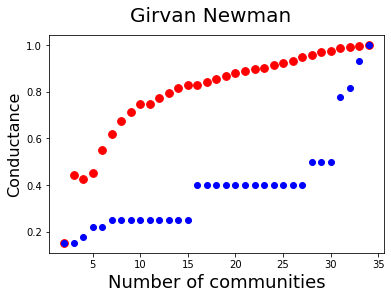

In [ ]:
#Plotting in red the conductance of the partition.
#Plotting in blue the minimum conductance across all communities of a partition (best conductance).
fig = plt.figure()
plt.scatter(x_g_n, y_g_n, color='r',s=60)
plt.scatter(x_g_n, y_min, color='b')
fig.suptitle('Girvan Newman', fontsize=20)
plt.xlabel('Number of communities', fontsize=18)
plt.ylabel('Conductance', fontsize=16)

In [ ]:
#Looking in detail the best partition
partition = best_partition_g_n

In [ ]:
conductances_dict, conductance_min, conductance = compute_conductance(G, partition)

Text(0, 0.5, 'Conductance')

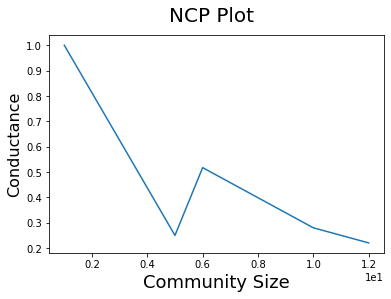

In [ ]:
lists = sorted(conductances_dict.items()) # sorted by key, return a list of tuples
x_g_n_sample, y_g_n_sample = zip(*lists) # unpack a list of pairs into two tuples
fig = plt.figure()
plt.plot(x_g_n_sample, y_g_n_sample)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
fig.suptitle('NCP Plot', fontsize=20)
plt.xlabel('Community Size', fontsize=18)
plt.ylabel('Conductance', fontsize=16)

In [ ]:
#Additionally, we compute the conductance using the best partition given by the modularity score
_, _, conductance_gn = compute_conductance(G, best_partition_g_n)

### Conductance on Spectral Clustering

In [ ]:
# Print conductance scores for all partitions and saving values for later plotting
x_spec = []
y_spec = []
y_min = []

for partition in spectral_partition:
    x_val = len(partition)
    conductances_dict, conductance_min, conductance = compute_conductance(G, partition)
    x_spec.append(x_val)
    y_spec.append(conductance)
    y_min.append(conductance_min)
    print("Number of Communities=",x_val,", conductance=",conductance,", conductance_min=",conductance_min)

Number of Communities= 2 , conductance= 0.28205128205128205 , conductance_min= 0.28205128205128205
Number of Communities= 3 , conductance= 0.5147058823529412 , conductance_min= 0.25
Number of Communities= 4 , conductance= 0.40895405887600356 , conductance_min= 0.13157894736842105
Number of Communities= 5 , conductance= 0.437409200968523 , conductance_min= 0.25
Number of Communities= 6 , conductance= 0.4845951035781544 , conductance_min= 0.25
Number of Communities= 7 , conductance= 0.5663197751791879 , conductance_min= 0.25
Number of Communities= 8 , conductance= 0.6560813615608136 , conductance_min= 0.25
Number of Communities= 9 , conductance= 0.6525738351825309 , conductance_min= 0.2753623188405797
Number of Communities= 10 , conductance= 0.8161904761904761 , conductance_min= 0.42857142857142855
Number of Communities= 11 , conductance= 0.8195670995670995 , conductance_min= 0.4
Number of Communities= 12 , conductance= 0.8361416361416362 , conductance_min= 0.4
Number of Communities= 13 

Text(0, 0.5, 'Conductance')

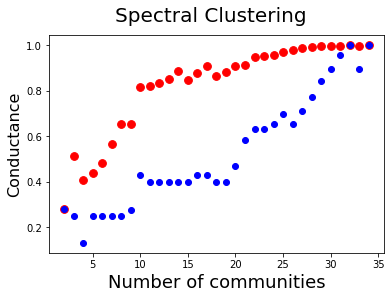

In [ ]:
#Plotting in red the conductance of the partition.
#Plotting in blue the minimum conductance across all communities of a partition.
fig = plt.figure()
plt.scatter(x_spec, y_spec, color='r',s=60)
plt.scatter(x_spec, y_min, color='b')
fig.suptitle('Spectral Clustering', fontsize=20)
plt.xlabel('Number of communities', fontsize=18)
plt.ylabel('Conductance', fontsize=16)

In [ ]:
#Additionally, we compute the conductance using the best partition given by the modularity score
_, _, conductance_spec = compute_conductance(G, best_partition_spec)

### Conductance on Louvain

In [ ]:
#Additionally, we compute the conductance using the best partition given by the modularity score
_, _, conductance_louvain = compute_conductance(G, best_partition_louvain)

### Conductance Comparison

In [ ]:
df = pd.DataFrame({
    "Girvan-Newman":[conductance_gn],
    "Spectral clustering": [conductance_spec],
    "Louvain algo": [conductance_louvain]})

df

,Girvan-Newman,Spectral clustering,Louvain algo
0,0.453516,0.437409,0.287933


## Coverage

In [ ]:
def compute_coverage(G, partition):
    '''
    :param G: input graph.
    :param partition: a list of node sets where each set represents a community.
    :return: coverage value for a given partition of the network G.
    '''  
    nodes_list = np.array(list(G.nodes()))
    A = nx.adj_matrix(G)    

    intra_edges = 0
    # Loop over communities
    for subset in partition:
        nodes_subset = list(subset) 
        intra_edges_c = 0
        # For all pair of nodes inside these communities
        for i_name in nodes_subset:
            #Reading i index based on Node name
            i = np.where(nodes_list == i_name)[0][0]
            for j_name in nodes_subset:    
                #Reading j index based on Node name
                j = np.where(nodes_list == j_name)[0][0]
                #Using indices to retrieve value from Adjacency matrix
                intra_edges_c += A[i,j]

        #We need to divide by 2 because if A(i,j) = 1 then A(j,i) = 1 as well
        intra_edges_c = intra_edges_c/2 
        #We need the number of intra coomunity edges of the whole graph
        intra_edges += intra_edges_c

    #Coverage is the ratio of the number of intra-community edges to the total number of edges
    return (intra_edges/G.number_of_edges())

### Coverage on Girvan Newman

In [ ]:
# Print coverage scores for all partitions and saving values for later plotting
x_g_n = []
y_g_n = []

for partition in girvan_newman_partition:
    x_val = len(partition)
    y_val = compute_coverage(G, partition)
    x_g_n.append(x_val)
    y_g_n.append(y_val)
    print(x_val,y_val)

2 0.8717948717948718
3 0.8461538461538461
4 0.7948717948717948
5 0.6923076923076923
6 0.6794871794871795
7 0.6538461538461539
8 0.6282051282051282
9 0.6025641025641025
10 0.5769230769230769
11 0.5512820512820513
12 0.5256410256410257
13 0.5
14 0.47435897435897434
15 0.44871794871794873
16 0.4230769230769231
17 0.3974358974358974
18 0.3717948717948718
19 0.358974358974359
20 0.32051282051282054
21 0.2948717948717949
22 0.2564102564102564
23 0.21794871794871795
24 0.19230769230769232
25 0.1794871794871795
26 0.16666666666666666
27 0.15384615384615385
28 0.1282051282051282
29 0.11538461538461539
30 0.07692307692307693
31 0.05128205128205128
32 0.038461538461538464
33 0.01282051282051282
34 0.0


Text(0.5, 0.98, 'Girvan Newman')

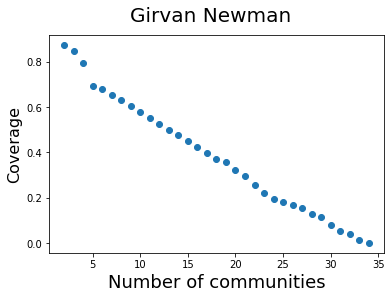

In [ ]:
fig = plt.figure()
plt.scatter(x_g_n, y_g_n)
plt.xlabel('Number of communities', fontsize=18)
plt.ylabel('Coverage', fontsize=16)
fig.suptitle('Girvan Newman', fontsize=20)

In [ ]:
#Additionally, we compute the coverage using the best partition given by the modularity score
coverage_gn = compute_coverage(G, best_partition_g_n)

### Coverage on Spectral Clustering

In [ ]:
# Print coverage scores for all partitions and saving values for later plotting
x_spec = []
y_spec = []

for partition in spectral_partition:
    x_val = len(partition)
    y_val = compute_coverage(G, partition)
    x_spec.append(x_val)
    y_spec.append(y_val)
    print(x_val,y_val)

2 0.8589743589743589
3 0.9358974358974359
4 0.8076923076923077
5 0.717948717948718
6 0.6794871794871795
7 0.6538461538461539
8 0.6025641025641025
9 0.6025641025641025
10 0.5769230769230769
11 0.6410256410256411
12 0.6153846153846154
13 0.5641025641025641
14 0.6025641025641025
15 0.5256410256410257
16 0.47435897435897434
17 0.5
18 0.4230769230769231
19 0.41025641025641024
20 0.34615384615384615
21 0.23076923076923078
22 0.3076923076923077
23 0.2948717948717949
24 0.24358974358974358
25 0.15384615384615385
26 0.1794871794871795
27 0.14102564102564102
28 0.10256410256410256
29 0.0641025641025641
30 0.02564102564102564
31 0.01282051282051282
32 0.0
33 0.01282051282051282
34 0.0


Text(0.5, 0.98, 'Spectral Clustering')

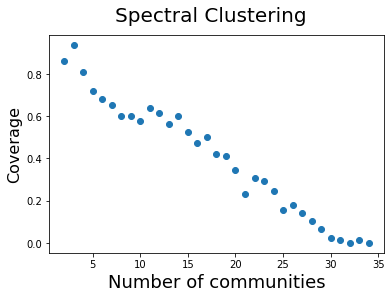

In [ ]:
fig = plt.figure()
plt.scatter(x_spec, y_spec)
plt.xlabel('Number of communities', fontsize=18)
plt.ylabel('Coverage', fontsize=16)
fig.suptitle('Spectral Clustering', fontsize=20)

In [ ]:
#Additionally, we compute the coverage using the best partition given by the modularity score
coverage_spec = compute_coverage(G, best_partition_spec)

### Coverage on Louvain

In [ ]:
#Additionally, we compute the coverage using the best partition given by the modularity score
coverage_louvain = compute_coverage(G, best_partition_louvain)

### Coverage Comparison

In [ ]:
df = pd.DataFrame({
    "Girvan-Newman":[coverage_gn],
    "Spectral clustering": [coverage_spec],
    "Louvain algo": [coverage_louvain]})

df

,Girvan-Newman,Spectral clustering,Louvain algo
0,0.692308,0.717949,0.730769


## Performance

In [ ]:
def compute_performance(G, partition):
    '''
    :param G: input graph.
    :param partition: a list of node sets where each set represents a community.
    :return: performance value for a given partition of the network G.
    '''  
    nodes_list = np.array(list(G.nodes()))
    A = nx.adj_matrix(G)

    intra_edges = 0
    # Loop over communities
    for subset in partition:
        nodes_subset = list(subset)
        intra_edges_c = 0
        # For all pair of nodes inside these communities
        for i_name in nodes_subset:
            #Reading i index based on Node name
            i = np.where(nodes_list == i_name)[0][0]
            for j_name in nodes_subset:    
                #Reading j index based on Node name
                j = np.where(nodes_list == j_name)[0][0]
                #Using indices to retrieve value from Adjacency matrix
                intra_edges_c += A[i,j]

        #We need to divide by 2 because if A(i,j) = 1 then A(j,i) = 1 as well
        intra_edges_c = intra_edges_c/2
        #We need the number of intra coomunity edges of the whole graph
        intra_edges += intra_edges_c

    #Sum of inter-community edges and intra-community edges gives us the total number of edges in the graph
    inter_edges = G.number_of_edges() - intra_edges

    #Computing number of inter-community non-edges (non-adjacent nodes belonging to different communities)
    inter_non_edges = 0
    for subset_i in partition:
        for subset_j in partition:
            #For different communities
            if subset_i != subset_j:
                #Computing number of nodes of first community
                nodelist_i = list(subset_i)
                G_subset_i = G.subgraph(nodelist_i)
                n_i = G_subset_i.number_of_nodes()
                #Computing number of nodes of second community
                nodelist_j = list(subset_j)
                G_subset_j = G.subgraph(nodelist_j)
                n_j = G_subset_j.number_of_nodes()
                #Multiplying number of nodes of both communities
                inter_non_edges += (n_i*n_j) 
    
    #Getting inter-community non-edges            
    inter_non_edges = inter_non_edges/2
    inter_non_edges = inter_non_edges - inter_edges

    #Defining numerator as the number of correctly interpreted pairs of nodes in the partition:
    #Adjacent nodes belonging to the same community + Non-adjacent nodes belonging to different communities 
    numerator = intra_edges + inter_non_edges
    n = G.number_of_nodes()
    #Defining denominator as the total number of potential edges
    denominator = (n*(n-1))/2
    
    #Return Performance
    return numerator/denominator

### Performance on Girvan Newman

In [ ]:
# Print performance scores for all partitions and saving values for later plotting
x_g_n = []
y_g_n = []

for partition in girvan_newman_partition:
    x_val = len(partition)
    y_val = compute_performance(G, partition)
    x_g_n.append(x_val)
    y_g_n.append(y_val)
    print(x_val,y_val)

2 0.6114081996434938
3 0.6363636363636364
4 0.7112299465240641
5 0.8110516934046346
6 0.8235294117647058
7 0.8360071301247772
8 0.8431372549019608
9 0.8538324420677362
10 0.8627450980392157
11 0.8716577540106952
12 0.8787878787878788
13 0.8841354723707665
14 0.8894830659536542
15 0.893048128342246
16 0.8966131907308378
17 0.9001782531194296
18 0.9019607843137255
19 0.9019607843137255
20 0.9001782531194296
21 0.9001782531194296
22 0.8966131907308378
23 0.8912655971479501
24 0.8877005347593583
25 0.8859180035650623
26 0.8841354723707665
27 0.8823529411764706
28 0.8787878787878788
29 0.8770053475935828
30 0.8716577540106952
31 0.8680926916221033
32 0.8663101604278075
33 0.8627450980392157
34 0.8609625668449198


Text(0.5, 0.98, 'Girvan Newman')

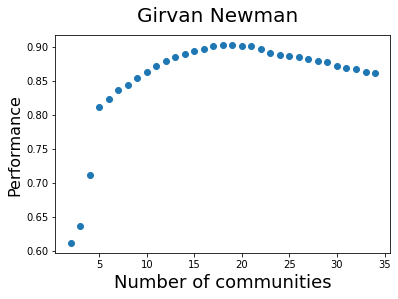

In [ ]:
fig = plt.figure()
plt.scatter(x_g_n, y_g_n)
plt.xlabel('Number of communities', fontsize=18)
plt.ylabel('Performance', fontsize=16)
fig.suptitle('Girvan Newman', fontsize=20)

In [ ]:
#Additionally, we compute the performance using the best partition given by the modularity score
performance_gn = compute_performance(G, best_partition_g_n)

### Performance on Spectral Clustering

In [ ]:
# Print performance scores for all partitions and saving values for later plotting
x_spec = []
y_spec = []

for partition in spectral_partition:
    x_val = len(partition)
    y_val = compute_performance(G, partition)
    x_spec.append(x_val)
    y_spec.append(y_val)
    print(x_val,y_val)

2 0.5276292335115864
3 0.4295900178253119
4 0.714795008912656
5 0.8057040998217468
6 0.8431372549019608
7 0.8431372549019608
8 0.8377896613190731
9 0.8467023172905526
10 0.7950089126559715
11 0.7718360071301248
12 0.7932263814616756
13 0.8288770053475936
14 0.803921568627451
15 0.8627450980392157
16 0.8698752228163993
17 0.8467023172905526
18 0.9019607843137255
19 0.9019607843137255
20 0.8841354723707665
21 0.8770053475935828
22 0.8734402852049911
23 0.8734402852049911
24 0.8734402852049911
25 0.8680926916221033
26 0.8698752228163993
27 0.8609625668449198
28 0.8609625668449198
29 0.8591800356506238
30 0.8591800356506238
31 0.857397504456328
32 0.857397504456328
33 0.8627450980392157
34 0.8609625668449198


Text(0.5, 0.98, 'Spectral Clustering')

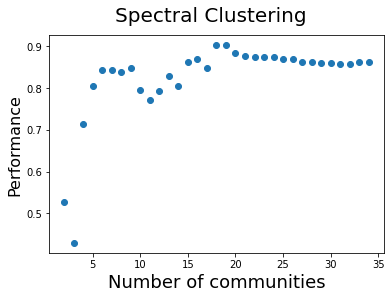

In [ ]:
fig = plt.figure()
plt.scatter(x_spec, y_spec)
plt.xlabel('Number of communities', fontsize=18)
plt.ylabel('Performance', fontsize=16)
fig.suptitle('Spectral Clustering', fontsize=20)

In [ ]:
#Additionally, we compute the performance using the best partition given by the modularity score
performance_spec = compute_performance(G, best_partition_spec)

### Performance on Louvain

In [ ]:
#Additionally, we compute the performance using the best partition given by the modularity score
performance_louvain = compute_performance(G, best_partition_louvain)

### Performance Comparison

In [ ]:
df = pd.DataFrame({
    "Girvan-Newman":[performance_gn],
    "Spectral clustering": [performance_spec],
    "Louvain algo": [performance_louvain]})

df

,Girvan-Newman,Spectral clustering,Louvain algo
0,0.811052,0.805704,0.803922


## Comparison Summary - NonOverlapping

In [ ]:
# initialise data of lists.
data = {'Number of Communities':[len(best_partition_g_n),len(best_partition_spec),len(best_partition_louvain)]}
  
# Creates pandas DataFrame.
df = pd.DataFrame(data, index =['Girvan-Newman',
                                'Spectral Clustering',
                                'Louvain Algo'])

df

,Number of Communities
Girvan-Newman,5
Spectral Clustering,5
Louvain Algo,4


In [ ]:
# initialise data of lists.
data = {'Girvan-Newman':[best_partition_eval_g_n, conductance_gn, coverage_gn, performance_gn],
        'Spectral Clustering':[best_partition_eval_spec, conductance_spec, coverage_spec, performance_spec],
        'Louvain Algo':[ best_partition_eval_louvain, conductance_louvain, coverage_louvain, performance_louvain]}
  
# Creates pandas DataFrame.
df = pd.DataFrame(data, index =['Modularity',
                                'Conductance',
                                'Coverage',
                                'Performance'])

df

,Girvan-Newman,Spectral Clustering,Louvain Algo
Modularity,0.401298,0.403189,0.418803
Conductance,0.453516,0.437409,0.287933
Coverage,0.692308,0.717949,0.730769
Performance,0.811052,0.805704,0.803922


## Modularity - Overlapping

In [ ]:
def compute_modularity_overlap(G, partition):
    '''
    :param G: input graph.
    :param partition: a list of node sets where each set represents a community.
    :return: modularity value for a given partition of the network G.
    '''    
    num_of_edges = G.number_of_edges()
    modularity_list = []
    
    n_communities = len(partition)
    node_belong_fact = {key: [0 for n in range(n_communities)] for key in G.nodes()}
    #First we need to compute the belonging factors
    for n in G.nodes():
        count_n = 0
        for subset_idx, subset in enumerate(partition):
            if n in subset:
                #Counting how many communities a node belongs to
                count_n += 1
                #Assigning mark 1 to ID it easily in the next step
                node_belong_fact[n][subset_idx] = -1
        #Computing belonging factor for each node     
        factor = 1/count_n
        #Updating belonging factor
        for subset_idx, curr_factor in enumerate(node_belong_fact[n]):
            if curr_factor == -1:
                node_belong_fact[n][subset_idx] = factor
        
    # Loop over communities
    for subset_idx, subset in enumerate(partition):
        nodelist = list(subset)
        G_subset = G.subgraph(nodelist)
        A = nx.adj_matrix(G_subset)
        
        s = 0
        # For all pair of nodes inside these communities
        for i in range(G_subset.number_of_nodes()):
            for j in range(G_subset.number_of_nodes()):
                s += ( A[i, j] - ( ( nx.degree(G, nodelist[i])*nx.degree(G, nodelist[j]) ) / (2.0*num_of_edges) ) )*((node_belong_fact[nodelist[i]][subset_idx] + node_belong_fact[nodelist[j]][subset_idx])/2)
            
        modularity_list.append(s / (2.0*num_of_edges))
            
    return np.sum(modularity_list)

### Modularity Overlapping on CPM

### Modularity Overlapping on BigClam

In [ ]:
def tune(G, A, min_C, max_C, min_cut, max_cut, step):
    maxi = 0
    maxi_C = 0
    maxi_c = 0
    cut = np.arange(min_cut, max_cut+step, step)
    for C in range(min_C, max_C):
        F = train(A, C)
        for c in cut:
            community = cutoff(F, c)
            output_sets = [set() for i in range(C)]
            for i in range(C):
                for j in np.where(community[:, i])[0]:
                    output_sets[i].add(str(j))
            try:
                cand = compute_modularity_overlap(G, output_sets)
                if cand > maxi:
                    maxi = cand
                    maxi_C = C
                    maxi_c = c
            except:
                continue
    return maxi, maxi_C, maxi_c

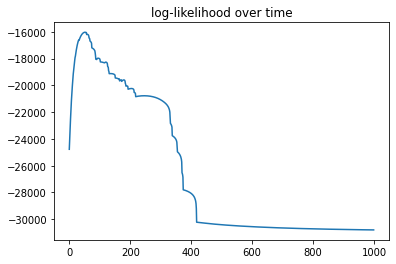

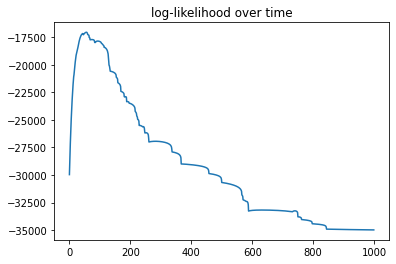

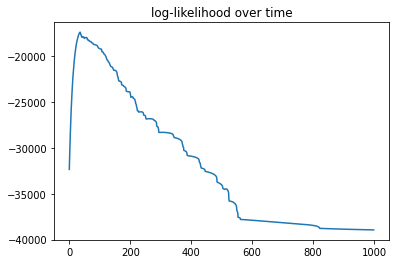

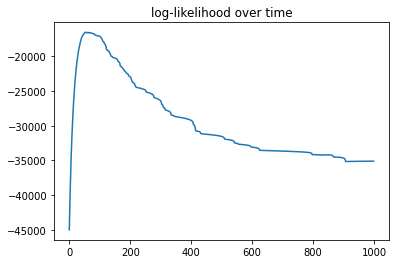

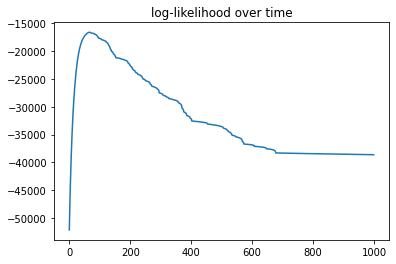

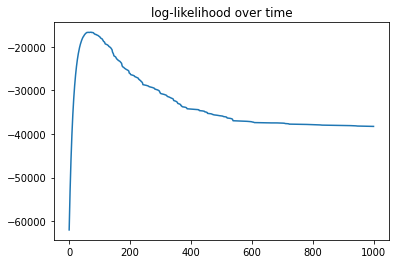

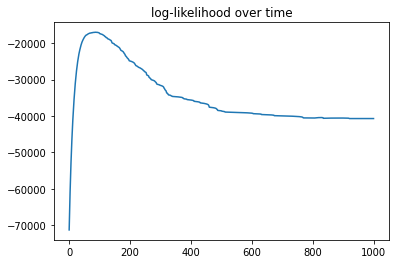

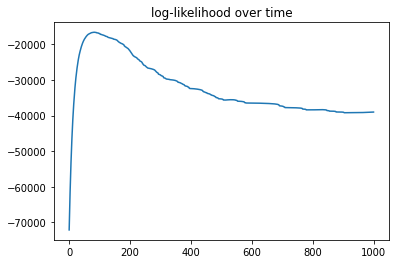

(0.39421022353714663, 4, 0.15000000000000002)


In [ ]:
A = nx.to_numpy_matrix(G)
print(tune(G, A, 2, 10, 0.01, 0.8, 0.01))

The modularity for the BigClam algorithm is in the range of 0.38 to 0.41.
In the example above, the best hyperparameter pair that yield the highest modularity is 4 communities and a cutoff of 0.15 with a modularity value of 0.394.

### Conclusion

In this project, we set out to implement and compare various community detection algorithms. We were able to study two strands of algorithms for this purpose the first one being non-overlapping algorithms while the second consisted of overlapping algorithms. The evaluation of the non-overlapping algorithm showed that the Louvain algorithm has the highest modularity, conductance and coverage while the Girvan-Newman algorithm has the best performance. On the other hand in terms of overlapping algorithm, we were only able to evaluate the performance of the BigClam algorithm for which we used overlapping modularity metric. The results were not very reproducible as the results oscillated between 0.38 and 0.41. Although the overlapping algorithm at its peak can perform better than the non-overlapping algorithms, the variation at the output can give low results. Study of the scalability of the algorithms leads us to believe non-overlapping algorithms
are the most viable options as the grant high results as well as being scalable. However, the Girvan-Newman algorithm has shown diffculty in scaling to bigger networks. Further work could include a thorough evaluation of the CPM algorithm.